In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

## Goal: Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

## Acquire

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


## Prepare

In [4]:
# Parse Datetime
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
df = df.set_index('timestamp')

In [5]:
# clean up text
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [6]:
# add column converting size from bytes to megabytes
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [7]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [8]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


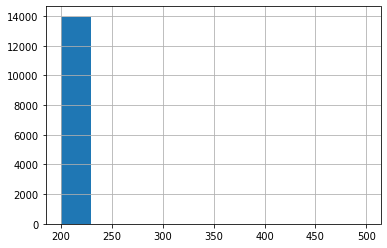

In [9]:
df.status.hist()

In [10]:
df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

In [11]:
df[df.status == 301]

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-17 19:36:41+00:00,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,NaN,python-requests/2.21.0,0.000958
2019-04-18 19:42:41+00:00,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,2560,NaN,python-requests/2.21.0,0.002441


In [12]:
df[df.status == 499]

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:55:15+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.20.1,0.0
2019-04-16 19:56:02+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.20.1,0.0
2019-04-16 20:28:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.21.0,0.0
2019-04-16 20:33:24+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.21.0,0.0
2019-04-16 20:38:13+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,NaN,python-requests/2.21.0,0.0
2019-04-16 20:38:55+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,NaN,python-requests/2.21.0,0.0
2019-04-16 20:39:00+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,NaN,python-requests/2.21.0,0.0
2019-04-16 20:45:17+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,NaN,python-requests/2.21.0,0.0
2019-04-16 20:45:28+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,NaN,python-requests/2.21.0,0.0


In [13]:
df.request_agent.value_counts()

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [14]:
df.size_mb.value_counts(bins=6)

(0.327, 0.654]       12321
(-0.00296, 0.327]     1655
(1.634, 1.961]           1
(0.981, 1.307]           1
(1.307, 1.634]           0
(0.654, 0.981]           0
Name: size_mb, dtype: int64

In [16]:
df.groupby(df.index.dayofweek).agg(['count'])

,ip,request_method,status,size,destination,request_agent,size_mb
,count,count,count,count,count,count,count
timestamp,,,,,,,
1,11947,11947,11947,11947,22,11947,11947
2,2028,2028,2028,2028,3,2028,2028
3,1,1,1,1,0,1,1
4,1,1,1,1,0,1,1
6,1,1,1,1,0,1,1
